# ヒストグラムを安易に使用するべきではない

In [1]:
using Distributions
using StatsPlots
default(fmt=:png, titlefontsize=10)

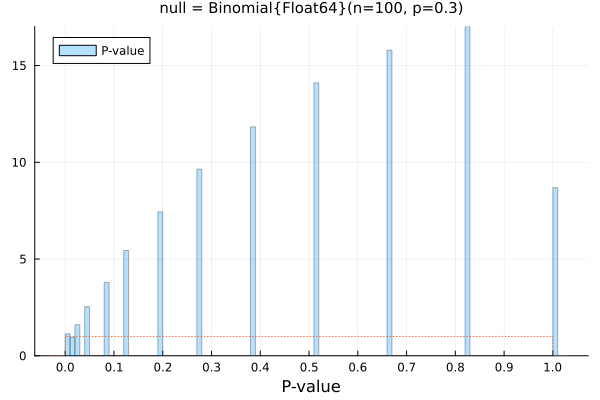

In [2]:
safediv(x, y) = x == 0 ? zero(x/y) : x/y

function pvalue_normal_approx(dist, x)
    μ, σ = mean(dist), std(dist)
    z = safediv(x - μ, σ)
    2ccdf(Normal(), abs(z))
end

null = Binomial(100, 0.3)
L = 10^6
X = rand(null, L)
Pval = pvalue_normal_approx.(null, X)

histogram(Pval; norm=true, alpha=0.3, label="P-value")
plot!(x -> 0 ≤ x ≤ 1 ? 1 : 0, -0.03, 1.03; label="", ls=:dot)
plot!(xtick=0:0.1:1)
plot!(xguide="P-value")
title!("null = $null")

上では正規分布近似による二項検定のP値の分布をヒストグラムで視覚化しようとしている。

仮想的なデータを生成している確率分布と帰無仮説の分布が等しいので、P値の分布は一様分布で近似されるはずなのだが、ヒストグラムを見るとそのように見えない。

このような場合にはヒストグラムを使用するべきではない。

代替案：経験累積分布函数をプロットする。

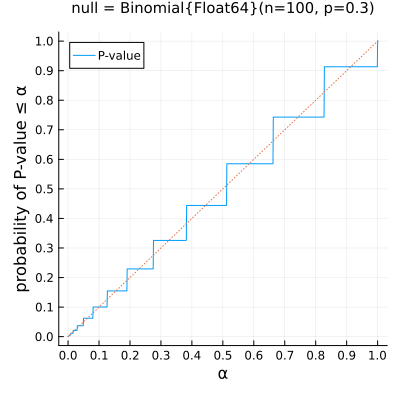

In [3]:
ECDF(A, x) = count(≤(x), A) / length(A)

xtick = ytick = 0:0.1:1
αs = range(0, 1.001, step=0.001)
plot(αs, α -> ECDF(Pval, α); label="P-value")
plot!(identity; ls=:dot, label="")
plot!(; xtick, ytick)
plot!(xguide="α", yguide="probability of P-value ≤ α")
title!("null = $null")
plot!(size=(400, 400))

一様分布の累積分布函数のグラフは45度線であり、P値の経験累積分布函数のグラフが45度線で近似されていることがわかる。

批判：統計学では $\alpha$ が小さいときにP値が $\alpha$ 以下になる確率が重要なのに、上のグラフではその様子がわからない。

解答例1： $0 \le \alpha \le 0.1$ の範囲に制限したグラフを描いてみる。

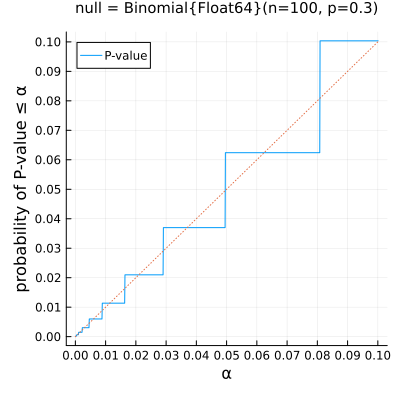

In [4]:
xtick = ytick = 0:0.01:1
αs = range(0, 0.1001, step=0.0001)
plot(αs, α -> ECDF(Pval, α); label="P-value")
plot!(identity; ls=:dot, label="")
plot!(; xtick, ytick)
plot!(xguide="α", yguide="probability of P-value ≤ α")
title!("null = $null")
plot!(size=(400, 400))

解答例2: 対数軸にする。

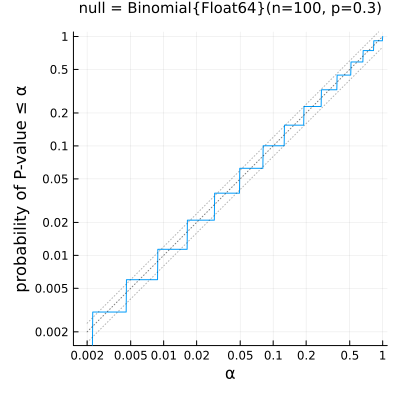

In [5]:
using StatsBase: ecdf

function plot_ecdfpval(pvals::AbstractArray{<:AbstractArray};
        n = length(pvals), 
        labels = fill("", n),
        linestyles = fill(:auto, n),
        size = (400, 400),
        legend = :bottomright,
        kwargs...
    )
    _tick = Any[0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
    xtick = ytick = (float.(_tick), string.(_tick))
    xlim = ylim = (0.0015, 1.1)
    αs = exp.(range(log(0.002), log(1), 1000))
    P = plot()
    for (pval, label, ls) in zip(pvals, labels, linestyles)
        _ecdf_pval = ecdf(pval)
        plot!(αs, α -> _ecdf_pval(α); label, ls, kwargs...)
    end
    plot!(αs, x->x; label="", ls=:dot, alpha=0.5, c=:black)
    plot!(αs, x->0.8x; label="", ls=:dot, alpha=0.3, c=:black)
    plot!(αs, x->1.2x; label="", ls=:dot, alpha=0.3, c=:black)
    plot!(; xscale=:log10, yscale=:log10, xtick, ytick, xlim, ylim)
    plot!(; xguide="α", yguide="probability of P-value ≤ α")
    plot!(; size, legend)
end

function plot_ecdfpval(pval::AbstractVector{<:Real};
        label = "", linestyle = :solid,
        size = (400, 400), legend = :bottomright, kwargs...)
    plot_ecdfpval([pval];
        labels = [label], linestyles = [linestyle],
        size, legend, kwargs...)
end

plot_ecdfpval(Pval)
title!("null = $null")

中心極限定理のデモンストレーションでも安易にヒストグラムを使うのは危険。

In [6]:
using Random: rand!

function sim_clt(dist, n; L=10^6)
    X̄ = zeros(L)
    S² = zeros(L)
    nth = Threads.nthreads()
    Xtmp = [zeros(eltype(dist), n) for _ in 1:nth]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        X = rand!(dist, Xtmp[tid])
        X̄[i] = mean(X)
        S²[i] = var(X)
    end
    X̄, S²
end

sim_clt (generic function with 1 method)

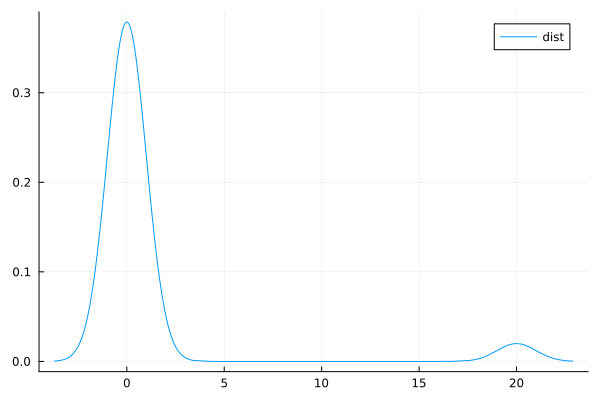

In [7]:
dist = MixtureModel([Normal(), Normal(20)], [0.95, 0.05])
plot(1dist; label="dist")

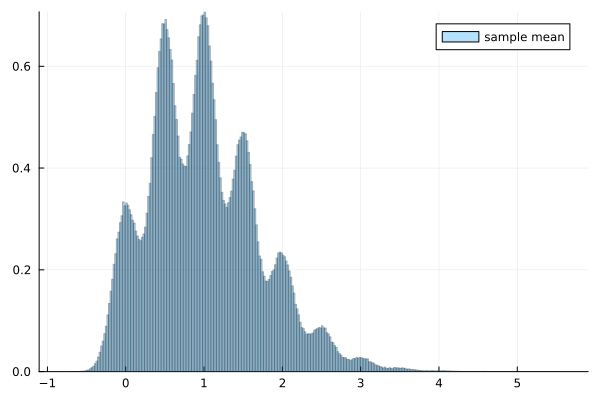

In [8]:
X̄, S² = sim_clt(dist, 40)

histogram(X̄; norm=true, alpha=0.3, label="sample mean")

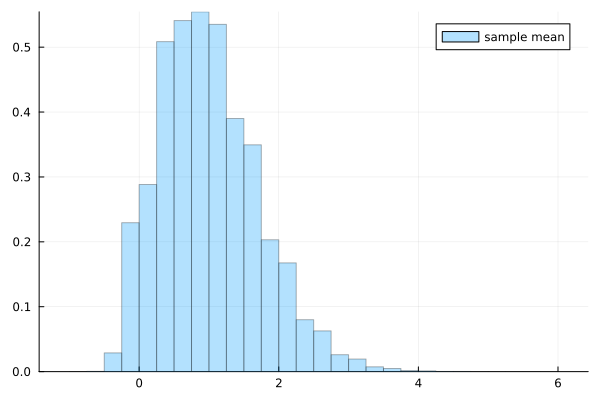

In [9]:
histogram(X̄; norm=true, alpha=0.3, bin=-1:0.25:6, label="sample mean")

このようにbinの取り方で出来上がるヒストグラムの印象はかなり変わる。

このような場合にはグラフによる印象操作にならないように注意する必要がある。

`histogram` の代わりに `stephist` を使うこともできる。

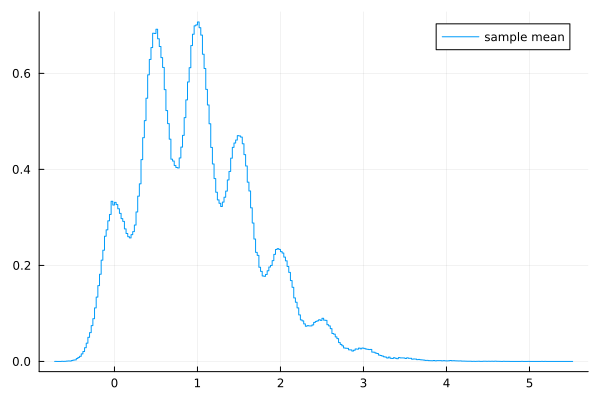

In [10]:
stephist(X̄; norm=true, label="sample mean")

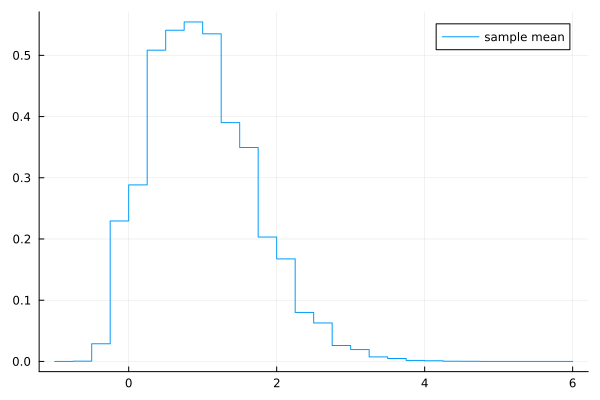

In [11]:
stephist(X̄; norm=true, bin=-1:0.25:6, label="sample mean")

おまけ: 標本平均と不偏分散の同時分布の視覚化は面白い。

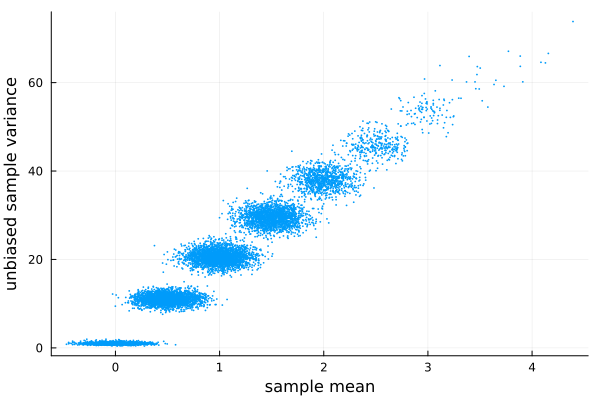

In [12]:
X̄, S² = sim_clt(dist, 40; L=10^4)

scatter(X̄, S²; ms=1, msc=:auto, alpha=1, label="")
plot!(xguide="sample mean", yguide="unbiased sample variance")